In [1]:
import os
import re
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
path_Corpus = 'F:/Data/TextDL_Learn/TextCorpus/'
corpa_name = path_Corpus + 'DL_Text_corpus_NATOupdated.txt'
label_names = path_Corpus + 'Label_numbersNATO.txt'

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.model_selection import GridSearchCV

In [4]:
#load corpus/docs and labels to list

def clean_str(text):
    text = text.replace(".", "")
    text = re.sub(r'[0-9,\n]',r'',text)
    text = re.sub(r'\s+',' ',text).strip()
    return text

with open(corpa_name) as file_doc:
    text_list = file_doc.readlines() #get corpus --> list 
    text = [clean_str(x) for x in text_list]
with open(label_names) as file_label:
    labels_list = file_label.readlines() #get corpus labels --> list
    label = list(map(lambda x:x.strip(),labels_list))

In [5]:
print(label[:10])

print(text[56:58])

X_train, X_test, y_train, y_test = train_test_split(text, label, test_size=0.2, random_state=0)


['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['th uth aprd resolution on the release of economic and industrial information the conference of national information officials from the northatlantic treaty countries at its meeting in london on thuth april unanimously agreed on the importance for their work of the release to the fullest extent compatible with security of information on the economic and industrial aspects of nato and of effective working arrangements within nato for regular and continuous supply of such information the conference recommended that the resolution be transmitted to the appropriate economic and industrial agencies belgrave square london declassified public disclosure dclassifi miseen lecture publique', 'qth april hato itokffaiiohal ifrto iaf icn th i hth aoril resolution on initiatlvo in the counter prooa ganda filid the conference of national information officiais at its meeting in london on th ith april ijjl conoioering that the soviet propaganda machin

In [6]:
count_vect = CountVectorizer()
content = count_vect.fit_transform(text)
content.shape

(17498, 297126)

In [7]:
tfidf_transformer = TfidfTransformer()
content_tfidf = tfidf_transformer.fit_transform(content)
content_tfidf.shape

(17498, 297126)

In [8]:
print("total train docs",len(X_train))
print("total train docs",len(X_test))

total train docs 13998
total train docs 3500


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

steps = [('vectorizer', CountVectorizer(stop_words='english')), ('tfidf', TfidfTransformer()), 
         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42))]

model = Pipeline(steps)
#y_train= np.reshape(y_train,(1,14876))
#y_test= np.reshape(y_test,(1,3720))

In [10]:
#paramater selection
#getting errors with SVC, asking for nu values -->yet to look
#checking linear svm (sdg)

model_svm = model.fit(X_train, y_train)
predicted_svm = model_svm.predict(X_test)
np.mean(predicted_svm == y_test)


C:\Users\raj99\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.622

In [11]:
# 62.3% accuracy for sdg classifier , linear svm 

#building new model with SVM, since there is class imbalance problem 

from sklearn.multiclass import OneVsRestClassifier

model_Newver = Pipeline([('vectorizer', CountVectorizer(stop_words='english')), ('tfidf', TfidfTransformer()),
    ('clf-onevs', OneVsRestClassifier(LinearSVC(class_weight="balanced")))])

In [12]:
#fit the new model onevs rest
# also build parameters

model_ovr = model_Newver.fit(X_train, y_train)
predicted_ovr = model_ovr.predict(X_test)
np.mean(predicted_ovr == y_test)

0.7128571428571429

In [13]:
#Seems to perform better, 
#lets do paramater selection


parameters_ovs = {'vectorizer__ngram_range': [(1, 1), (1, 2),(2,2)],
               'tfidf__use_idf': (True, False)}

gs_clf_ovs = GridSearchCV(model_Newver, parameters_ovs, n_jobs=-1)
gs_clf_ovs = gs_clf_ovs.fit(X_train, y_train)

print(gs_clf_ovs.best_score_)
print(gs_clf_ovs.best_params_)


C:\Users\raj99\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.710744392056008
{'tfidf__use_idf': True, 'vectorizer__ngram_range': (1, 2)}


In [14]:
#learn parameters sdg


parameters = {'vectorizer__ngram_range': [(1, 1), (1, 2),(2,2)],
               'tfidf__use_idf': (True, False), 'clf-svm__alpha': (1e-2, 1e-3)}
gs_clf_svm = GridSearchCV(model, parameters, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train, y_train)
print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)


#got 64% accuracy with parameter tuning and strange result on tfidf

C:\Users\raj99\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\raj99\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.6348764109158451
{'clf-svm__alpha': 0.001, 'tfidf__use_idf': False, 'vectorizer__ngram_range': (1, 1)}


In [18]:
#fit the model with new params one vs rest

#preparing the final pipeline using the selected parameters

model_ovr = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,2), stop_words='english')),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', OneVsRestClassifier(LinearSVC(class_weight="balanced")))])

#fit model with training data
model_ovr.fit(X_train, y_train)

#evaluation on test data
pred = model_ovr.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score

cm_sdg = confusion_matrix(pred, y_test)

accuracy = np.trace(cm_sdg) / float(np.sum(cm_sdg))
misclass = 1 - accuracy


In [19]:
import itertools
def plot_confusion_matrix(cm,accuracy,misclass,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [20]:
#fit the model with new params sdg

#preparing the final pipeline using the selected parameters

model_svm = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,1), stop_words='english')), 
                      ('tfidf', TfidfTransformer(use_idf=False)), 
         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=0.001, n_iter=5, random_state=42))])


#fit model with training data
model_svm.fit(X_train, y_train)

#evaluation on test data
pred_svm = model_svm.predict(X_test)


cm_svm =confusion_matrix(pred_svm, y_test)
accuracy_svm = np.trace(cm_svm) / float(np.sum(cm_svm))
misclass_svm = 1 - accuracy


C:\Users\raj99\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [21]:
print("one vs rest: ", 100* (np.mean(pred == y_test)))
print("SDG: ", 100* (np.mean(pred_svm == y_test)))

one vs rest:  73.54285714285714
SDG:  64.02857142857142


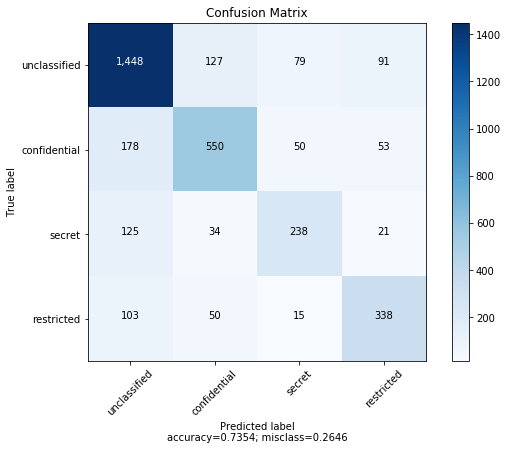

In [23]:
plot_confusion_matrix(cm_sdg,accuracy,misclass, normalize = False, 
                      target_names = ['unclassified', 'confidential', 'secret', 'restricted'], 
                      title = "Confusion Matrix" )

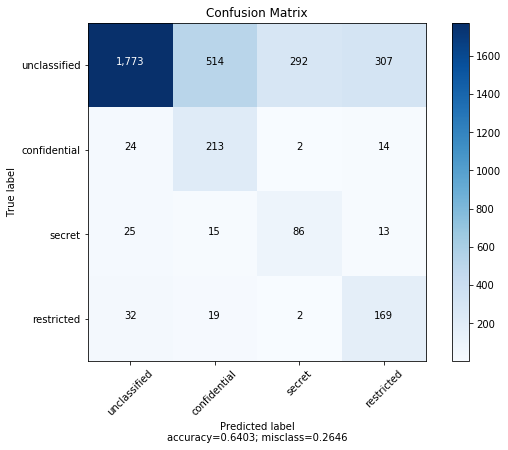

In [24]:
plot_confusion_matrix(cm_svm,accuracy_svm,misclass_svm, normalize = False, 
                      target_names = ['unclassified', 'confidential', 'secret', 'restricted'], 
                      title = "Confusion Matrix" )